In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import random

from sklearn import preprocessing
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchinfo import summary
from torch import optim 
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix

torch.__version__ 

'1.11.0'

In [2]:
# !nvidia-smi

# Data prep

In [3]:
class CarDataset(Dataset): 
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.label_df = pd.read_csv(f'{self.root_dir}/labels.csv')
  
  def __len__(self):
    return len(self.label_df)
  
  def __getitem__(self, idx): 
    data = self.label_df.iloc[idx]
    img = Image.open(f"{self.root_dir}/{data['index']}.jpg").convert('RGB')
    if self.transform is not None: 
        transformed_img = self.transform(img) 
    else: 
        transformed_img = img 
    kind = data['kind']
    return transformed_img, kind

In [4]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [5]:
unnormalizer = UnNormalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

In [6]:
img_size = 224
batch_size = 10

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])

train_dataset = CarDataset('../data/train', train_transform)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True)
val_dataset = CarDataset('../data/val', val_transform)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=True, pin_memory=True)
test_dataset = CarDataset('../data/test', test_transform)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True, pin_memory=True)

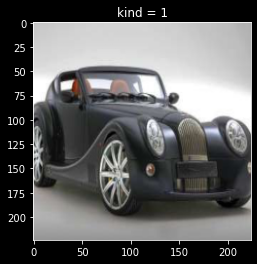

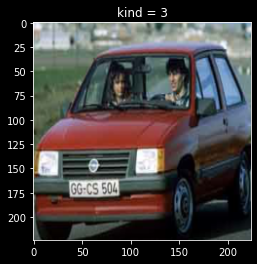

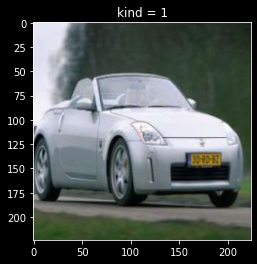

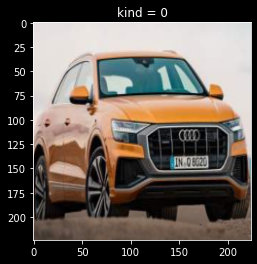

In [7]:
for idx in range(4): 
  img, kind = train_dataset[idx] 
  img = unnormalizer(img) 
  plt.title(f'kind = {kind}')  
  plt.imshow(np.transpose(img, (1,2,0)))
  plt.show()

# Model

In [8]:
import torchvision.models as models

class CNNNetwork(nn.Module):
    def __init__(self): 
        super().__init__()
        self.vgg = models.vgg11()
        self.ff = nn.Linear(1000, 5)
        self.softmax = nn.Softmax(dim=1)
    

    def forward(self, x):
        y = self.vgg(x)
        y = self.ff(y)
        y = self.softmax(y)
        return y

In [9]:
cnn_model = CNNNetwork()

In [10]:
# summary(cnn_model, input_size=(1,3,224,224))

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=2e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, min_lr=1e-8)

# Train

In [12]:
num_epochs = 20
device = "cuda" if torch.cuda.is_available() else "cpu"
cnn_model.to(device)

train_losses = []
val_losses = []
min_val_loss = float('inf')

for epoch in tqdm(range(num_epochs)):
    cnn_model.train()
    total_train_loss = 0
    for img, label in train_dataloader:
        img = img.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        outputs = cnn_model(img)
        train_loss = criterion(outputs, label)
        train_loss.backward()
        optimizer.step()
        total_train_loss += train_loss.item()
    current_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(current_train_loss)

    total_val_loss = 0
    cnn_model.eval()
    with torch.no_grad():
        for val_img, val_label in val_dataloader:
            val_img = val_img.to(device)
            val_label = val_label.to(device)
            val_outputs = cnn_model(val_img)
            val_loss = criterion(val_outputs, val_label)
            total_val_loss += val_loss.item()
    current_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(current_val_loss)
    if current_val_loss < min_val_loss: 
        min_val_loss = current_val_loss 
        torch.save(cnn_model.state_dict(), 'best_weights.pth')
    print(f'Epoch {epoch+1} - Train loss = {current_train_loss:.4f} - Val loss = {current_val_loss:.4f} - best min_val_loss = {min_val_loss:.4f} - lr = {optimizer.param_groups[0]["lr"]:.8f}') 
    scheduler.step(current_val_loss)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 - Train loss = 1.5245 - Val loss = 1.5096 - best min_val_loss = 1.5096 - lr = 0.00002000
Epoch 2 - Train loss = 1.5172 - Val loss = 1.5091 - best min_val_loss = 1.5091 - lr = 0.00002000
Epoch 3 - Train loss = 1.5042 - Val loss = 1.4961 - best min_val_loss = 1.4961 - lr = 0.00002000
Epoch 4 - Train loss = 1.5033 - Val loss = 1.5154 - best min_val_loss = 1.4961 - lr = 0.00002000
Epoch 5 - Train loss = 1.5040 - Val loss = 1.4929 - best min_val_loss = 1.4929 - lr = 0.00002000
Epoch 6 - Train loss = 1.5039 - Val loss = 1.4938 - best min_val_loss = 1.4929 - lr = 0.00002000
Epoch 7 - Train loss = 1.4953 - Val loss = 1.4920 - best min_val_loss = 1.4920 - lr = 0.00002000
Epoch 8 - Train loss = 1.4960 - Val loss = 1.5016 - best min_val_loss = 1.4920 - lr = 0.00002000
Epoch 9 - Train loss = 1.4876 - Val loss = 1.4911 - best min_val_loss = 1.4911 - lr = 0.00002000
Epoch 10 - Train loss = 1.4780 - Val loss = 1.4851 - best min_val_loss = 1.4851 - lr = 0.00002000
Epoch 11 - Train loss = 1.480

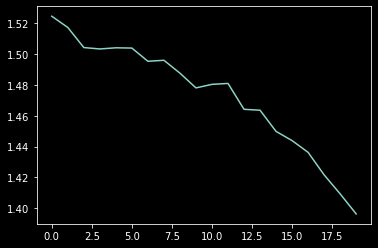

In [13]:
plt.plot(train_losses)
plt.show()

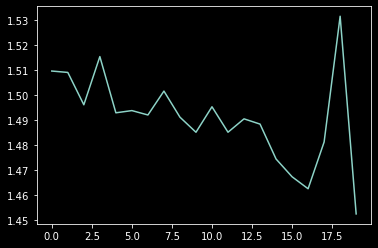

In [14]:
plt.plot(val_losses)
plt.show()

# Test

In [15]:
cnn_model.load_state_dict(torch.load('best_weights.pth'))

<All keys matched successfully>

tensor([[5.7473e-01, 4.4620e-05, 7.6250e-05, 1.1399e-01, 3.1115e-01]])


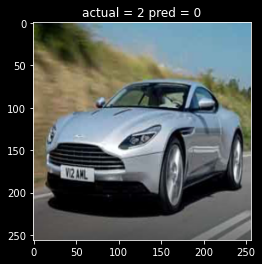

tensor([[5.4244e-01, 1.1887e-05, 2.0196e-05, 3.8361e-01, 7.3918e-02]])


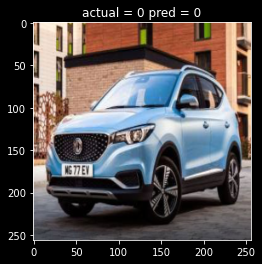

tensor([[0.6265, 0.0028, 0.0037, 0.0461, 0.3209]])


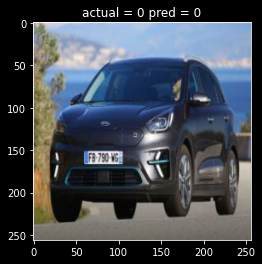

tensor([[1.5237e-03, 7.2959e-06, 1.5009e-05, 1.1470e-02, 9.8698e-01]])


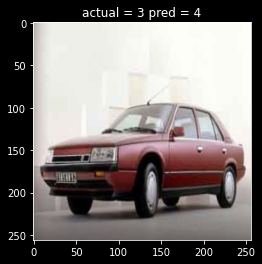

tensor([[0.4652, 0.0007, 0.0009, 0.5194, 0.0138]])


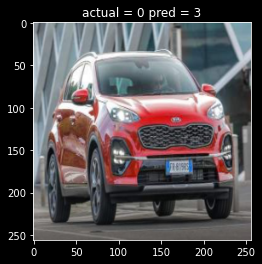

In [16]:
cnn_model.eval()
with torch.no_grad():
    for idx in range(5): 
        img, kind = test_dataset[idx] 
        outputs = cnn_model(img.unsqueeze(0).to(device)).detach().cpu()
        print(outputs)
        pred = torch.argmax(outputs)
        img = unnormalizer(img)
        plt.title(f'actual = {kind} pred = {pred}')  
        plt.imshow(np.transpose(img, (1,2,0)))
        plt.show()

In [17]:
cnn_model.eval()
labels = np.array([])
preds = np.array([])
with torch.no_grad():
    for img, label in test_dataloader:
        outputs = cnn_model(img.to(device)).detach().cpu()
        pred = torch.argmax(outputs, dim=1)
        labels = np.concatenate((labels, label.numpy()))
        preds = np.concatenate((preds, pred.numpy()))

In [18]:
confusion_matrix(labels, preds)

array([[ 51,   0,   0,  37,  24],
       [ 14,   0,   0,  31,  12],
       [  7,   0,   0,  41,  21],
       [ 31,   0,   0, 133,  58],
       [ 28,   0,   0,  45,  62]], dtype=int64)